# Introduction to Sampling Methods

### Goals 
There are two goals for this lab:
- To further acquaint you with MUQ, including random number generators and model construction.
- To develop a deeper understanding of methods for sampling from general distributions
    - Nonlinear transformations
    - Rejection Sampling
    - Markov chain Monte Carlo (MCMC)
    - Importance Sampling

### Problem Description
To illustrate these topics, we will consider the infamous "Banana" distribution, which is also called the "Boomerang" distribution in some circles.

Consider a standard normal random variable $z\sim N(0,I)$.  For some $a,b>0$, consider the transformation $m=S(z)$ given by

$$
m = \left[\begin{array}{c} m_1 \\ m_2 \end{array} \right] = S(z) = \left[\begin{array}{l} a z_1 \\ \frac{1}{a} z_2 + b (az_1)^2 + ba^2 \end{array}\right].
$$

With this transformation, sampling $m$ can be accomplished by drawing a random sample of $z$ and then evaluating $S(z)$.   

We will also sample $m$ using other methods that require evaluating the density $p(m)$.  To evaluate the density, we need to inverse transformation $T(m)=z$, which takes the form

$$
z = \left[\begin{array}{c} z_1 \\ z_2 \end{array} \right] = T(m) = \left[\begin{array}{l} \frac{1}{a} m_1 \\ a m_2 + ab(m_1^2 + a^2) \end{array}\right].
$$


Let $p_z(z)$ denote the Gaussian density on $z$.  Then the density on $M$ is given by

$$
p_m(m) = p_z(T(m))\,\left|\det{\nabla T}\right|
$$

where $\left|\det{\nabla T}\right|$ denotes the determinant of the Jacobian matrix of $T(m)$. The $p_m(m)$ is the *banana density* and (for $a=1$) it looks like:
<img src="BananaDensity.png" height=200px alt="Banana Density">


The form of $p_m(m)$ can also be simplified by considering the determinant term in more detail.   The Jacobian is given by

$$
\nabla T(m) = \left[ \begin{array}{cc} \frac{1}{a} & 0\\ 2ab m_1& a\end{array} \right].
$$

The determinant of a lower triangular matrix is the product of the digaonal entries, so $\left|\det{\nabla T}\right| = \frac{1}{a} a$.  Interestingly, the determinant of this Jacobian is always $1$, regardless of $a$ and $m$!  Thus, **for this problem** $p_m(m) = p_z(T(m))$.  It is important to note that this is a very special case and in general, the determinant term is required to define $p_m(m)$.

In [1]:
import sys
sys.path.insert(0,'/home/fenics/Installations/MUQ_INSTALL/lib')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import Image

In [2]:
import pymuqUtilities as mu
from pymuqUtilities import RandomGenerator as rg

import pymuqModeling as mm

## Background: Simple Random number generation
Below are a few examples of generating random variables in MUQ for a few canonical distributions.  The functions described here will serve as building blocks for more sophisticated sampling techniques.

#### Continuous Random Variables

In [3]:
numSamps = 5000
paramDim = 2

rg.SetSeed(2012)

# Gaussian Samples
gaussScalar = rg.GetNormal()
gaussVector = rg.GetNormal(paramDim)
gaussMatrix = rg.GetNormal(paramDim, numSamps)

# Uniform Samples
uniformScalar = rg.GetUniform()
uniformVector = rg.GetUniform(paramDim)
uniformMatrix = rg.GetUniform(paramDim, numSamps)

# Gamma Samples
gammaAlpha = 0.5
gammaBeta = 1.0

gammaScalar = rg.GetGamma(gammaAlpha, gammaBeta)
gammaVector = rg.GetGamma(gammaAlpha, gammaBeta, paramDim)
gammaMatrix = rg.GetGamma(gammaAlpha, gammaBeta, paramDim, numSamps)

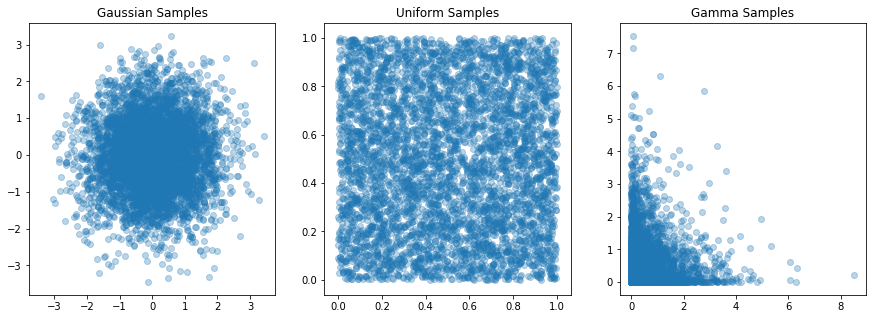

In [4]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].scatter(gaussMatrix[0,:], gaussMatrix[1,:], alpha=0.3)
axs[0].set_title('Gaussian Samples')

axs[1].scatter(uniformMatrix[0,:], uniformMatrix[1,:], alpha=0.3)
axs[1].set_title('Uniform Samples')

axs[2].scatter(gammaMatrix[0,:], gammaMatrix[1,:], alpha=0.3)
axs[2].set_title('Gamma Samples')


plt.show()

#### Integer Random Variables

In [5]:
lb = 0
ub = paramDim*numSamps

isUnique = False
intScalar = rg.GetUniformInt(lb,ub)
intVector = rg.GetUniformInt(lb, ub, paramDim, isUnique)
intMatrix = rg.GetUniformInt(lb, ub, paramDim, numSamps, isUnique)

isUnique = True
uniqueIntScalar = rg.GetUniformInt(lb, ub)
uniqueIntVector = rg.GetUniformInt(lb, ub, paramDim, isUnique)
uniqueIntMatrix = rg.GetUniformInt(lb, ub, paramDim, numSamps, isUnique)

Text(0.5,1,'Unique Random Integers')

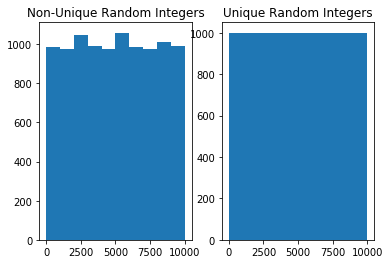

In [6]:
fig, axs = plt.subplots(ncols=2)

axs[0].hist(intMatrix.ravel())
axs[0].set_title('Non-Unique Random Integers')

axs[1].hist(uniqueIntMatrix.ravel())
axs[1].set_title('Unique Random Integers')

## The MUQ `ModPiece` class

MUQ provides many tools that need to interact with user defined models or model components.  The MUQ `ModPiece` class provides a mechanism for defining models (i.e., input-output relationships) in a way that MUQ can understand.   To define a new model, the user creates a class that inherits from the `PyModPiece` class (or just `ModPiece` in c++), overrides the `EvaluateImpl` function, and tells the parent `PyModPiece` class the size and number of inputs and outputs the new model has.  Note that these model components can have multiple inputs and multiple outputs.

For more information on classes and inheritance in Python, check out [this introduction](http://introtopython.org/classes.html).

For example, the following class implements the "Banana" transformation from $z\rightarrow m$.

The `EvaluateImpl` function takes a list of input vectors and sets the `self.outputs` member variable, which is also a list of vectors.

The `__init__` function in the `BananaTrans` class must call `PyModPiece.__init__` and specify the number of inputs and outputs.  The `PyModPiece.__init__` function has three inputs:
 - `self`
 - A list of integers specifying the size of each model input
 - A list of integers specifying the size of each model output

In [7]:
class BananaTrans(mm.PyModPiece):
    def __init__(self, a, b):
        mm.PyModPiece.__init__(self, [2], # One input containing 2 components
                                     [2]) # One output containing 2 components
        
        self.a = a
        self.b = b
        
    def EvaluateImpl(self, inputs):
        z = inputs[0]
        
        m = np.zeros((2))
        m[0] = self.a * z[0]
        m[1] = z[1]/self.a - self.b*((self.a*z[0])**2 + self.a**2)
        
        self.outputs = [m]

        

### Derivatives in the `ModPiece` class 
Many algorithms require derivative information to be efficient.  To add this information to a child of `PyModPiece`, we can override additional functions.  In particular,
- the `JacobianImpl` function can be overridden to implement the Jacobian
- the `GradientImpl` function can be overriden to implement Gradients, including adjoint gradients (i.e., computation of $J^Tv$ for some vector $v$)
- the `ApplyJacobianImpl` function can be overriden to implement Jacobian actions (i.e., $Jv$)

Below, we override the `JacobianImpl` function in the inverse banana transformation to provide Jacobian information.

In [8]:
class InvBananaTrans(mm.PyModPiece):
    
    def __init__(self, a, b):
        mm.PyModPiece.__init__(self, [2], # One input containing 2 components
                                     [2]) # One output containing 2 components
        self.a = a
        self.b = b
        print(self.a)
        
    def EvaluateImpl(self, inputs):
        m = inputs[0]
        
        z = np.zeros((2))
        z[0] = m[0]/self.a
        z[1] = m[1]*self.a + self.a*self.b*(m[0]**2 + self.a**2)
        self.outputs = [z]
        
    def JacobianImpl(self, outDimWrt, inDimWrt, inputs):
        m = inputs[0]
        self.jacobian = np.array([ [1.0/self.a, 0], [2.0*self.a*self.b*m[0], self.a] ])
        
    # TODO: Override the GradientImpl function, i.e. $J^T v$, where $v$ is the "sens" input
    def GradientImpl(self, outDimWrt, inDimWrt, inputs, sens):
    #     ...  Do a bunch of stuff here ...
    #     self.gradient = ?     
        self.gradient = self.Jacobian(outDimWrt, inDimWrt, inputs).T @ sens

In [9]:
a = 1.0
b = 1.0
invf = InvBananaTrans(a,b)

# TODO: Test your gradient by comparing it with a finite difference gradient
sens = np.ones((2))
m = np.array([0,-2])

fdGrad = invf.GradientByFD(0,0,[m],sens)
grad = invf.Gradient(0,0,[m],sens)

print('Finite Difference Gradient =\n', fdGrad)
print('Analytical Gradient =\n', grad)

1.0
Finite Difference Gradient =
 [ 1.          0.99999999]
Analytical Gradient =
 [ 1.  1.]


## Sampling via Nonlinear Transformations

In [10]:
# Illustration that ModPiece output is a list
f = BananaTrans(a,b)

z = np.array([0,0])
modPieceOutput = f.Evaluate([ z ])

print('Transformation Output = \n', modPieceOutput)

Transformation Output = 
 [array([ 0., -1.])]


In [11]:
zDist = mm.Gaussian(np.zeros((paramDim)))

In [12]:
# TODO: Use the f object to generate "numSamps" samples of the banana random variable m
# RECALL: The Gaussian class has a Sample() function

In [13]:
mSamps = np.zeros((paramDim, numSamps))
for i in range(numSamps):
    mSamps[:,i] = f.Evaluate([ zDist.Sample() ])[0]
    

In [14]:
# TODO: For each sample above, use the invf compute the value of the banana density
# RECALL: The Gaussian distribution from Friday has a LogDensity(z) function

In [15]:
logDensVals1 = np.zeros(numSamps)

for i in range(numSamps):
    jac = invf.Jacobian(0,0, [ mSamps[:,i] ])
    z = invf.Evaluate([ mSamps[:,i] ])
    logDensVals1[i] = zDist.LogDensity(z) + np.linalg.slogdet(jac)[1]

In [16]:
# TODO: Create a scatter plot of the banana samples (hint: use plt.scatter)

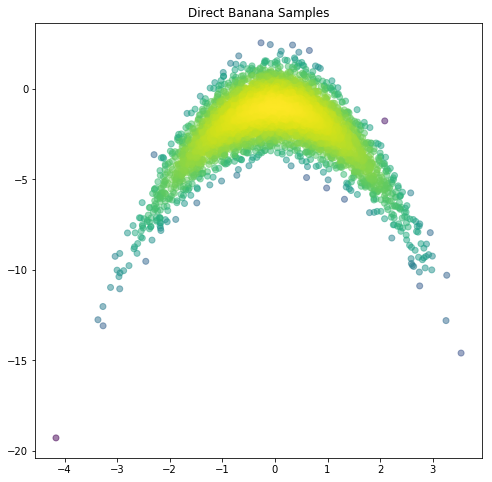

In [17]:
plt.figure(figsize=(8,8))

plt.scatter(mSamps[0,:],mSamps[1,:],c=logDensVals1, alpha=0.5)
plt.title('Direct Banana Samples')
plt.show()

### The WorkGraph class 
In MUQ, the `WorkGraph` class allows us to combine multiple model components (i.e., `ModPiece` instance).   Here, we will create a new model that evaluates $\log p_m(m) = \log p_z(T(m))$.  We will do this by combining an instance of `InvBananaTrans` with a Gaussian density.


First, we need to construct a graph with two nodes and one edge.

In [18]:
graph = mm.WorkGraph()

graph.AddNode(zDist.AsDensity(), "Gaussian Reference")
graph.AddNode(invf, "Banana Transformation")

graph.AddEdge("Banana Transformation", 0, "Gaussian Reference", 0)

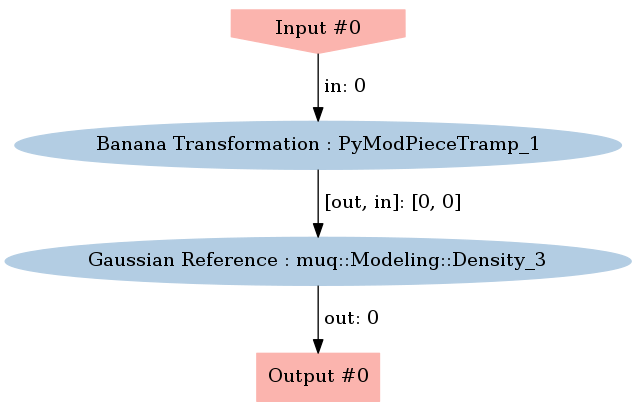

In [19]:
graph.Visualize("EvaluationGraph.png")
Image(filename='EvaluationGraph.png') 

Now that the graph is constructed, we can create the new model (in the form of a `ModPiece`).  Here, we use the `CreateModPiece` function, but takes the name of the output node as an argument.

In [20]:
tgtDens = graph.CreateModPiece("Gaussian Reference")

In [21]:
# TODO: Use the tgtDens.Evaluate function to evaluate $\log p_m(m)$ at each sample point.

In [22]:
logDensVals2 = np.zeros(numSamps)

for i in range(numSamps):
    logDensVals2[i] = tgtDens.Evaluate([ mSamps[:,i] ])[0] # NOTE: This only works because the jacobian is 1

In [23]:
# TODO: Plot the new density evaluations, do they match the results above?

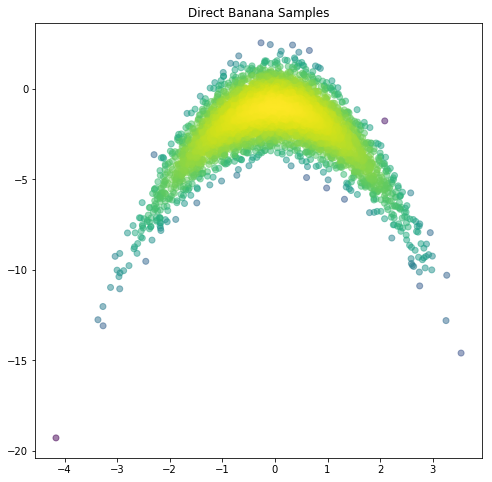

In [24]:
plt.figure(figsize=(8,8))

plt.scatter(mSamps[0,:],mSamps[1,:],c=logDensVals2, alpha=0.5)
plt.title('Direct Banana Samples')
plt.show()

# Rejection Sampling

In [25]:
propMu = np.array([0,-4])
propCov = np.array([ [4, 0],
                     [0, 20]])

propDist = mm.Gaussian(propMu, propCov)

In [26]:
rejectSamps = np.zeros((paramDim, numSamps))
rejectDens = np.zeros((numSamps))

In [27]:
# TODO: Implement a rejection sampler that samples from the banana density.

In [28]:
M = 3.0

sampInd = 0 # How many samples have been accepted so far
numEvals = 0 # Keep track of how many target density evaluations were needed

while(sampInd<numSamps):
    
    numEvals += 1
    
    propSamp = propDist.Sample()
    logTgt = tgtDens.Evaluate([propSamp])[0]
    logProp = propDist.LogDensity(propSamp)
    
    assert logTgt < M + logProp
    
    acceptProb = np.exp(logTgt  - M - logProp)
    
    if(rg.GetUniform()<acceptProb):
        rejectSamps[:,sampInd] = propSamp
        rejectDens[sampInd] = logTgt
        sampInd += 1
        
print('%d target density evaluations were needed to compute %d samples'%(numEvals, numSamps))

99350 target density evaluations were needed to compute 5000 samples


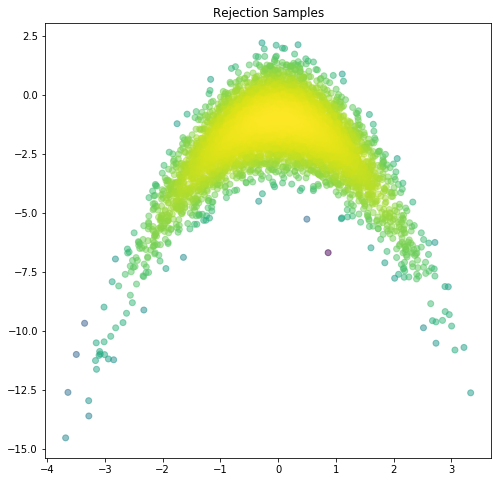

In [29]:
plt.figure(figsize=(8,8))

plt.scatter(rejectSamps[0,:], rejectSamps[1,:], c=rejectDens, alpha=0.5)
plt.title('Rejection Samples')
plt.show()

# Markov Chain Monte Carlo Sampling

In [30]:
propMu = np.zeros((paramDim))
propCov = 4.0*np.eye(paramDim)

mcmcProp = mm.Gaussian(propMu, propCov)

In [31]:
mcmcSamps = np.zeros((paramDim, numSamps))
mcmcDens = np.zeros((numSamps))

In [32]:
# TODO: Implement a simple random walk Metropolis algorithm to sample from the banana density.

In [33]:
currPt = np.zeros((paramDim))
currLogTgt = tgtDens.Evaluate([propSamp])[0]

numAccepts = 0

for i in range(numSamps):
    propSamp = mcmcProp.Sample()
    
    propLogTgt = tgtDens.Evaluate([propSamp])[0]
    
    u = np.exp(propLogTgt - currLogTgt)
    if(rg.GetUniform() < u):
        numAccepts += 1
        
        mcmcSamps[:,i] = propSamp
        
        currPt = propSamp
        currLogTgt = propLogTgt
    else:
        mcmcSamps[:,i] = currPt
    
print('Acceptance Rate = %f'%(float(numAccepts)/numSamps))

Acceptance Rate = 0.221000


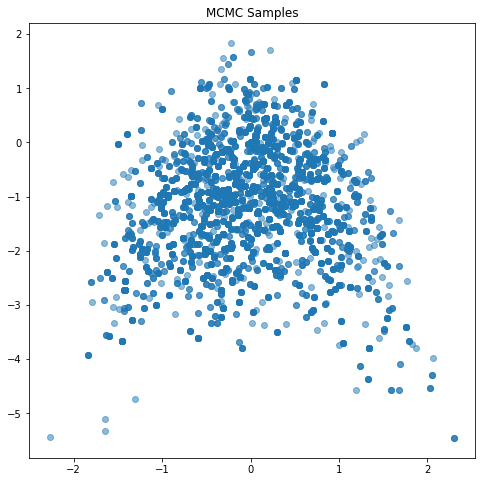

In [34]:
plt.figure(figsize=(8,8))

plt.scatter(mcmcSamps[0,:], mcmcSamps[1,:], alpha=0.5)
plt.title('MCMC Samples')
plt.show()

In [35]:
# TODO: Plot the MCMC chain.  Does it look like white noise?  Should it?

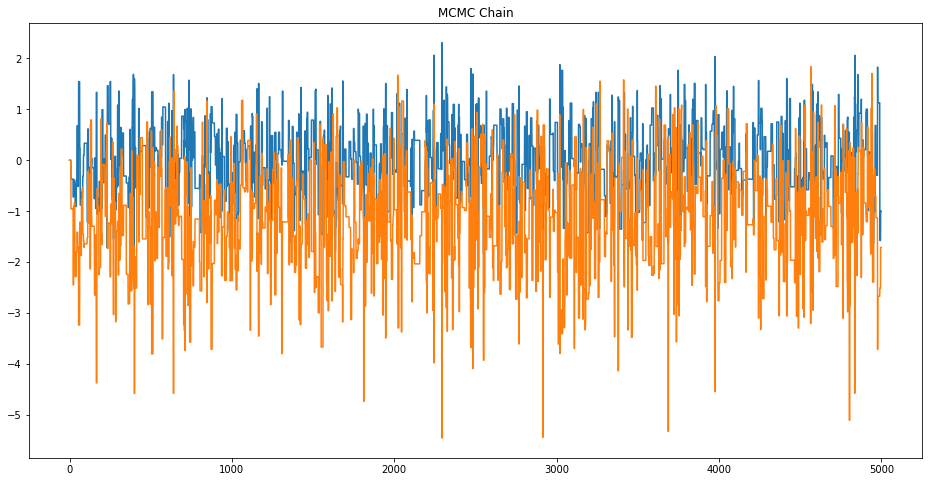

In [36]:
plt.figure(figsize=(16,8))

plt.plot(mcmcSamps[0,:])
plt.plot(mcmcSamps[1,:])

plt.title('MCMC Chain')
plt.show()


# Importance Sampling

In [37]:
propMu = np.array([0,-4])
propCov = np.array([ [4, 0],
                     [0, 20]])

isProp = mm.Gaussian(propMu, propCov)

In [38]:
# TODO: Estimate the Banana density mean using an importance sampler

In [39]:
isSamps   = np.zeros((paramDim, numSamps))
isWeights = np.zeros((numSamps))

for i in range(numSamps):
    isSamps[:,i] = isProp.Sample()
    isWeights[i] = np.exp( tgtDens.Evaluate([isSamps[:,i]])[0] - isProp.LogDensity(isSamps[:,i]) )

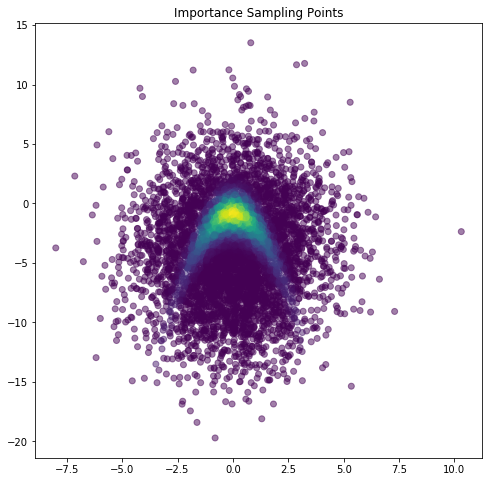

In [40]:
plt.figure(figsize=(8,8))
plt.scatter(isSamps[0,:], isSamps[1,:], c=isWeights, alpha=0.5)
plt.title('Importance Sampling Points')
plt.show()

In [41]:
isMean = np.dot(isSamps, isWeights) / np.sum(isWeights)
print('Importance Sampling mean = ', isMean)

Importance Sampling mean =  [ 0.04996654 -1.99683488]
